# DMASS tutorial

esutil and healpy should be installed 

In [2]:
import os, sys
import esutil
import healpy as hp
import numpy as np
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
# call required functions from modules 
sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS_Y3 import priorCut_test

# Construct training samples

We first need to load Y3 Gold catalogs in the overlapping region (training region) and split them into the cmass sample and non-cmass sample. 

In [4]:
# Calling Y3 GOLD v2.0 (training)
# All catalogs are in the 'input_path' directory 
# The 'SearchAndCallFits' function below loads all 
# catalogs in the directory including 'input_keyword' in its name
#input_path = '/n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/'
input_path = '/global/cscratch1/sd/bwarner/'
# call only first 9 catalogs for a fast run.
# to call all catalogs in the directory, use 'Y3_GOLD' as input_keyword 
# but that will consume huge memory
input_keyword = 'Y3_GOLD_2_0_STRIPE82'  
# Columns to call
columns =  ['RA', 'DEC', 
            'HPIX_4096',     # Healpix in ring order, nside=4096
            'COADD_OBJECT_ID', 
            'SOF_CM_MAG_CORRECTED_G', # mag_[griz]
            'SOF_CM_MAG_CORRECTED_R',
            'SOF_CM_MAG_CORRECTED_I',
            'SOF_CM_MAG_CORRECTED_Z',
            'SOF_CM_MAG_ERR_G',       # mag error_[griz]
            'SOF_CM_MAG_ERR_R',
            'SOF_CM_MAG_ERR_I',
            'SOF_CM_MAG_ERR_Z']
gold_st82 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Color/Magnitude cuts to exclude extremely high or low mag/color sources.
# 16 < mag_riz < 24, 0 < (r-i) < 1.5, 0 < (g-r) < 2.5
# These galaxies are less likeliy to be a CMASS, therefore unnecessary. 
# We apply these cuts to reduce the sample size to speed up the codes
mask_magcut = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_magcut]


Calling catalogs >>>
Y3_GOLD_2_0_STRIPE82_000059.fits
Y3_GOLD_2_0_STRIPE82_000006.fits
Y3_GOLD_2_0_STRIPE82_000047.fits
Y3_GOLD_2_0_STRIPE82_000126.fits
Y3_GOLD_2_0_STRIPE82_000080.fits
Y3_GOLD_2_0_STRIPE82_000003.fits
Y3_GOLD_2_0_STRIPE82_000045.fits
Y3_GOLD_2_0_STRIPE82_000037.fits
Y3_GOLD_2_0_STRIPE82_000118.fits
Y3_GOLD_2_0_STRIPE82_000134.fits
Y3_GOLD_2_0_STRIPE82_000070.fits
Y3_GOLD_2_0_STRIPE82_000066.fits
Y3_GOLD_2_0_STRIPE82_000030.fits
Y3_GOLD_2_0_STRIPE82_000116.fits
Y3_GOLD_2_0_STRIPE82_000092.fits
Y3_GOLD_2_0_STRIPE82_000120.fits
Y3_GOLD_2_0_STRIPE82_000035.fits
Y3_GOLD_2_0_STRIPE82_000129.fits
Y3_GOLD_2_0_STRIPE82_000112.fits
Y3_GOLD_2_0_STRIPE82_000023.fits
Y3_GOLD_2_0_STRIPE82_000083.fits
Y3_GOLD_2_0_STRIPE82_000106.fits
Y3_GOLD_2_0_STRIPE82_000034.fits
Y3_GOLD_2_0_STRIPE82_000014.fits
Y3_GOLD_2_0_STRIPE82_000004.fits
Y3_GOLD_2_0_STRIPE82_000013.fits
Y3_GOLD_2_0_STRIPE82_000090.fits
Y3_GOLD_2_0_STRIPE82_000101.fits
Y3_GOLD_2_0_STRIPE82_000021.fits
Y3_GOLD_2_0_STRIPE82_

Loading BOSS CMASS photometric sample

In [6]:
# cmass catalog is stored in cosmos machine
#cmass_filename = '/n/des/lee.5922/data/cmass_cat/cmass-dr12v4-S-Reid-full.dat.fits'
cmass_filename = '/global/homes/b/bwarner/DMASS/code/galaxy_DR11v1_CMASS_South-photoObj.fits.gz'
cmass = esutil.io.read(cmass_filename)

# Add healpix index (nside=4096) to the CMASS catalog
healConfig = {'map_inside':4096,
              'out_nside':4096,
              'nest':False}
cmass = HealPixifyCatalogs(catalog=cmass, healConfig=healConfig, ratag='RA', dectag = 'DEC')

Now we find the CMASS galaxies in the DES Y3 GOLD catalog by matching positions of galaxies.  

In [7]:
# this function returns indices of common galaxies (CMASS) in each catalog. 
# mg1: indices of common galaxies in cmass catalog
# mg2: indicies of common galaxies in Y3 GOLD catalog 
mg1, mg2, _ = esutil.htm.HTM(10).match(cmass['RA'], cmass['DEC'], gold_st82['RA'], \
                                     gold_st82['DEC'],2./3600, maxmatch=1)
# Apply indices to each catalog to select common galaxies. 
# Selected galaxies are then ordered in the same way. 
# (i.e clean_cmass_data_sdss[0] and clean_cmass_data_des[0] are the same galaxy) 
clean_cmass_data_sdss = cmass[mg1]           # common galaxies in cmass catalog
clean_cmass_data_des = gold_st82[mg2] # common galaxies in Y3 Gold

# We also need non-CMASS galaxies in the DES Y3 gold catalog
cmass_mask = np.zeros(gold_st82.size, dtype=bool)
cmass_mask[mg2] = 1
nocmass = gold_st82[~cmass_mask]

print(('num of cmass in des side', clean_cmass_data_des.size, '({:0.0f}%)'.format(clean_cmass_data_des.size*1./cmass.size*100.)))

('num of cmass in des side', 52063, '(28%)')


In [61]:
# save the samples. 
outdir = '../output/test/train_cat/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'train_cmass_sample_sdss.fits', clean_cmass_data_sdss, overwrite=True)
esutil.io.write( outdir+'train_cmass_sample_des.fits', clean_cmass_data_des, overwrite=True)
esutil.io.write( outdir+'train_non_cmass_sample_des.fits', nocmass, overwrite=True)

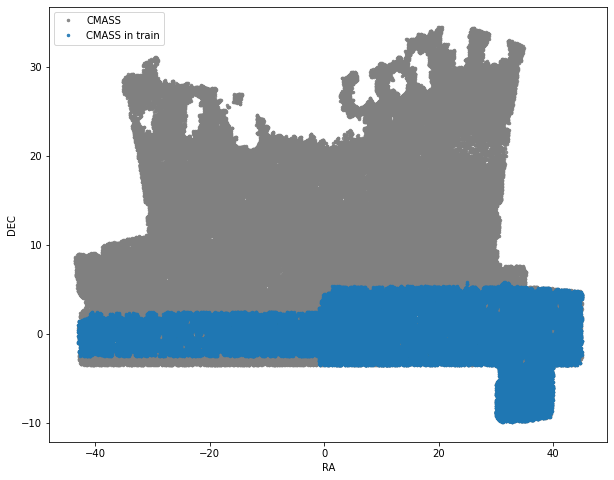

In [62]:
# Plotting footprint
spatialcheck([cmass, clean_cmass_data_des], 
             label = ['CMASS', 'CMASS in train'], convert = None, ratag='RA',dectag='DEC')

In [8]:
#Healpixels:



# Footprints of Train and Test regions

Codes for computing the areas of the training and test regions. 
This is not needed to run the DMASS algorithm. Only included this here as you asked before. 

In [63]:
# calling Y3 GOLD footprint map
# downloaded from https://cdcvs.fnal.gov/redmine/projects/des-y3/wiki/Y3A2_Gold_footprint
mapname='/global/homes/b/bwarner/DMASS/code/y3a2_footprint_griz_1exp_v2.0.fits.gz.1'
hpmap_y3gold = hp.read_map(mapname)
goodmask = hp.mask_good(hpmap_y3gold)
hpind_y3gold = np.arange(hpmap_y3gold.size)

# Generate mask for cmass
mask_train = np.in1d(cmass['HEALIndex'],hpind_y3gold[goodmask])

# Apply mask to extract cmass in the Y3 gold region
# This results 76722 CMASS galaxies
train_sample = cmass[mask_train]

/global/homes/b/bwarner/.conda/envs/DES_env/lib/python3.9/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


OSError: Header missing END card.

In [14]:
# convert hp indices to ra/dec and split into st82 (training) and spt (test) regions. 
# Apply a rough cut (DEC > -10.0)
ra_hpmap_y3gold, dec_hpmap_y3gold = hpHEALPixelToRaDec( hpind_y3gold[goodmask], nside = 4096, nest=False )
mask_hpmap_y3gold_training = dec_hpmap_y3gold > -10.0
mask_hpmap_y3gold_testing = dec_hpmap_y3gold < -10.0

pixarea = hp.nside2pixarea( 4096, degrees = True)
npix_training =  np.sum(mask_hpmap_y3gold_training)
npix_testing = np.sum(mask_hpmap_y3gold_testing)
TrainingMapArea = pixarea * npix_training
TestingMapArea = pixarea * npix_testing
print ('<Survey Area> \n-This is a rough estimation')
print ('training region (dec > -10.0):{:5.0f} sq.deg'.format(TrainingMapArea) )
print ('testing region  (dec < -10.0):{:5.0f} sq.deg'.format(TestingMapArea) )

NameError: name 'hpind_y3gold' is not defined

# Training the algorithm

In [64]:
# call training samples
outdir = '../output/test/train_cat/'
clean_cmass_data_des = esutil.io.read( outdir+'train_cmass_sample_des.fits')
nocmass = esutil.io.read( outdir+'train_non_cmass_sample_des.fits')

In [72]:
# For a fast run, we draw a random sample to reduce the sample size. 
# Larger sample tends to make a better model but the sample size is not always proportional to the accuracy of the model. 

# Put sample size you want 

n_sample =  100000  # train cmass sample size
n_sample_non = int(nocmass.size)          # train non-cmass sample size

#n_sample =  int(clean_cmass_data_des.size)  # train cmass sample size
#n_sample_non = int(nocmass.size/20)          # train non-cmass sample size

print('random sampling... ')
sampling_ind = np.random.choice(np.arange(clean_cmass_data_des.size), size = n_sample)
clean_cmass_data_des_sub = clean_cmass_data_des[sampling_ind]
print('num of randomly sampled cmass ', clean_cmass_data_des_sub.size)
random_sampling_ind = np.random.choice(np.arange(nocmass.size), size = n_sample_non )
nocmass_sub = nocmass[random_sampling_ind]
print('num of randomly sampled non-cmass ', nocmass_sub.size)

# The fraction of CMASS galaxies in the training region.
# This number is required to put a prior for the Bayesian statistics 
cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
print('cmass_fraction (cmass/non-cmass): ', cmass_fraction)
outdir = '../output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
f = open(outdir+'cmassfrac', 'w')
f.write('{0:.10f}'.format(cmass_fraction))
f.close()

random sampling... 
num of randomly sampled cmass  100000
num of randomly sampled non-cmass  64622
cmass_fraction (cmass/non-cmass):  3.173529870142928e-05


### Model Fitting

In [73]:
# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_cmass = None    # for cmass
n_no = None       # for non-cmass 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_cmass = 10
n_iter_no = 1
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = '../output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
cmass_pickle = outdir+'gauss_cmass.pkl'
no_pickle = outdir+'gauss_no.pkl'

In [74]:
# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I']

# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_cmass_true, X_cmass_cov = mixing_color(clean_cmass_data_des_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

# This generates four columns of non-cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_no_true, X_no_cov = mixing_color(nocmass_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

In [75]:
# Run XD Fitting. This will take a while 
clf_cmass = XD_fitting_X( X_cmass_true, X_cmass_cov, pickleFileName = cmass_pickle, 
                       n_cl = n_cmass, n_iter = n_iter_cmass, tol = tol, 
                       verbose = True, init_params= None)                 
clf_no = XD_fitting_X( X_no_true, X_no_cov, pickleFileName = no_pickle, 
                    n_cl = n_no, n_iter = n_iter_no, tol = tol, 
                    verbose = True, init_params = None)

@pickle_results: computing results and saving to '../output/test/fitting/gauss_cmass.pkl'
    - args match:   False
    - kwargs match: True
@pickle_results: using precomputed results from '../output/test/fitting/gauss_cmass.pkl.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  8
n components = 8
tolerance = 1e-05


/global/homes/b/bwarner/.conda/envs/DES_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


1: log(L) = 356568.5092
    (9.6 sec)
2: log(L) = 357310.7851
    (10 sec)
3: log(L) = 357801.5043
    (9.5 sec)
4: log(L) = 358197.4517
    (9.6 sec)
5: log(L) = 358566.1718
    (9.6 sec)
6: log(L) = 358939.3637
    (9.5 sec)
7: log(L) = 359325.3327
    (9.5 sec)
8: log(L) = 359719.8454
    (9.3 sec)
9: log(L) = 360114.2592
    (9.2 sec)
10: log(L) = 360496.0725
    (9.3 sec)
elapsed time: 1.40 min,  total iteration 9                                 
@pickle_results: computing results and saving to '../output/test/fitting/gauss_no.pkl'
    - args match:   False
    - kwargs match: True
@pickle_results: using precomputed results from '../output/test/fitting/gauss_no.pkl.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  16
n components = 16
tolerance = 1e-05


/global/homes/b/bwarner/.conda/envs/DES_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


1: log(L) = 88170.04941
    (12 sec)
elapsed time: 0.00 min,  total iteration 0                                 


# Validation of the fitted XD model

In [76]:
# call saved pickles if you empty memory. Otherwise skip it 
outdir = '../output/test/fitting/'
cmass_pickle = outdir+'gauss_cmass.pkl'
no_pickle = outdir+'gauss_no.pkl'
clf_cmass = XD_fitting_X( None, None, pickleFileName = cmass_pickle)               
clf_no = XD_fitting_X( None, None, pickleFileName = no_pickle)

In [77]:
# We will generate a random sample from the fitted model and compare the resulting samples with the training sample
# If the model is correct, the random sample should match with the training sample
X_sample_cmass = clf_cmass.sample(200000)  # cmass model
X_sample_no = clf_no.sample(200000)        # non-cmass model

Using central 100% to set range.


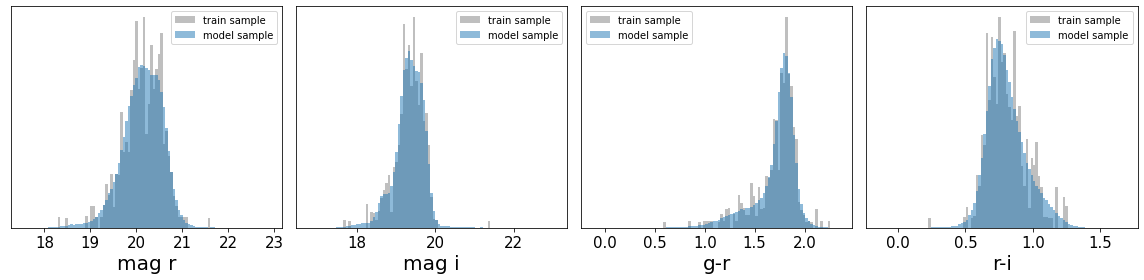

In [78]:
# Comparison. train vs. randoms from the fitted gaussian mixture model
doVisualization_1d( data=[X_cmass_true, X_sample_cmass], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100)

Using central 100% to set range.


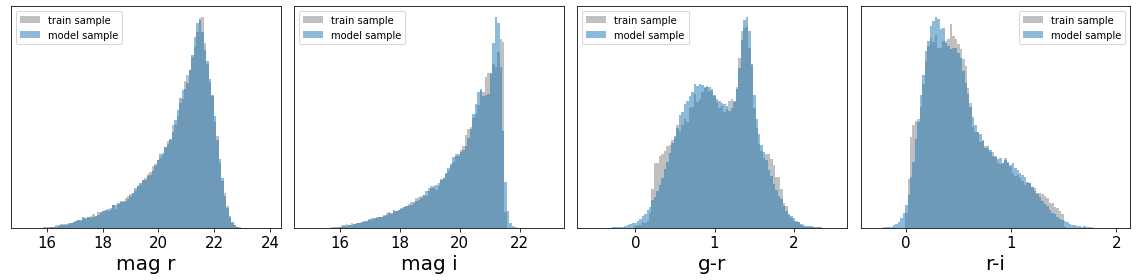

In [79]:
# Comparison. train vs. randoms for non-cmass
doVisualization_1d( data=[X_no_true, X_sample_no], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100)

If model samples agree with the training samples, we will use the fitted model to assign a CMASS membership probability to the Y3 Gold galaxies. First, try with the training region. As the model is trained with the training region, the assigned probability should reflect the color distributions of the taining galaxies. 

In [80]:
# For a fast run, we use a subset of y3 gold selected randomly.  
# Generate random indices, sample size 100,000
rand_ind = np.random.choice(np.arange(gold_st82.size), size = 100000)
gold_st82_sub = gold_st82[rand_ind]

# Assigning CMASS probabilities to Gold Y3 in Stripe 82.
mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'] 
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'] 
filter = ['G', 'R', 'I']
gold_st82_test = assignCMASSProb(gold_st82_sub, clf_cmass, clf_no, 
                     cmass_fraction = cmass_fraction, 
                     mag=mag, err=err, filter=filter )

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 


The probability is saved into the `CMASS_PROB` column. `y3 gold` galaxies should be weighted with this column to be a DMASS galaxy. Now we will compare the color/magnitude distributions of the weighted `y3 gold` galaxies (DMASS) with the training sample

In [81]:
# Generate Four columns of data : mag r, mag i, (g-r), (r-i)
X_dmass_st82, Xcov = mixing_color(gold_st82_test, 
                mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'], 
                err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'], 
                filter = ['G', 'R', 'I'],
                no_zband = True  )

Using central 100% to set range.


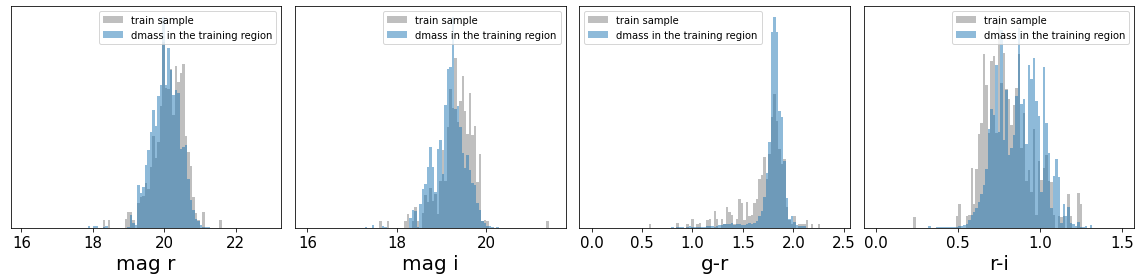

In [82]:
# Comparison plot for the training sample (cmass) vs. dmass sample selected in the training region
# DMASS sample should be weighted by 'CMASS_PROB' column when plotting
weight_dmass = gold_st82_test['CMASS_PROB']
doVisualization_1d( data=[X_cmass_true, X_dmass_st82], 
                   weight = [None, weight_dmass], # put DMASS weight here 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'dmass in the training region'], 
                   nbins=100)

# Apply the fitted model to galaxies outside the training region

If the fitted model works well in the training region, we will apply the model to `y3 gold` galaxies outside the training region. We call a small patch of `y3 gold` at `-40 < dec < -30`, `10 < ra < 20`. 

In [83]:
# empty memory 
gold_st82 = None
gold_st82_sub = None
nocmass = None

In [84]:
# Calling Y3 GOLD in a small square area 
input_path = '/global/cscratch1/sd/bwarner/'
input_keyword = 'Y3_GOLD_2_0_SPT_ra10_20'
columns = \
['RA', 'DEC', 'HPIX_4096', 
'COADD_OBJECT_ID', 
'SOF_CM_MAG_CORRECTED_G',
'SOF_CM_MAG_CORRECTED_R',
'SOF_CM_MAG_CORRECTED_I',
'SOF_CM_MAG_CORRECTED_Z',
'SOF_CM_MAG_ERR_G',
'SOF_CM_MAG_ERR_R',
'SOF_CM_MAG_ERR_I',
'SOF_CM_MAG_ERR_Z']
gold_spt = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Apply the same color/mag cuts to exclude extreme color/mag sources 
mask_magcut = priorCut_test(gold_spt)
gold_spt = gold_spt[mask_magcut]


Calling catalogs >>>
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000004.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000006.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000007.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000012.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000008.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000013.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000015.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000003.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000016.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000011.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000009.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000010.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000014.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000002.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000017.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000001.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000005.fits
reading 1/17 /global/cscratch1/sd/bwarner/Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000004.fits
reading 2/17 /global/cscratch1/sd/bwarner/Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000006.fits
r

In [85]:
# For a fast run, draw a random sample to reduce the sample size 
rand_ind = np.random.choice(np.arange(gold_spt.size), size = 100000)
gold_spt_sub = gold_spt[rand_ind]

# Assigning CMASS probabilities to Gold Y3
mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'] 
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'] 
filter = ['G', 'R', 'I']
gold_spt_test = assignCMASSProb(gold_spt_sub, clf_cmass, clf_no, 
                     cmass_fraction = cmass_fraction, 
                     mag=mag, err=err, filter=filter )

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 


In [86]:
X_dmass, Xcov = mixing_color(gold_spt_test, 
                mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'], 
                err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'], 
                filter = ['G', 'R', 'I'],
                no_zband = True  )

Using central 100% to set range.


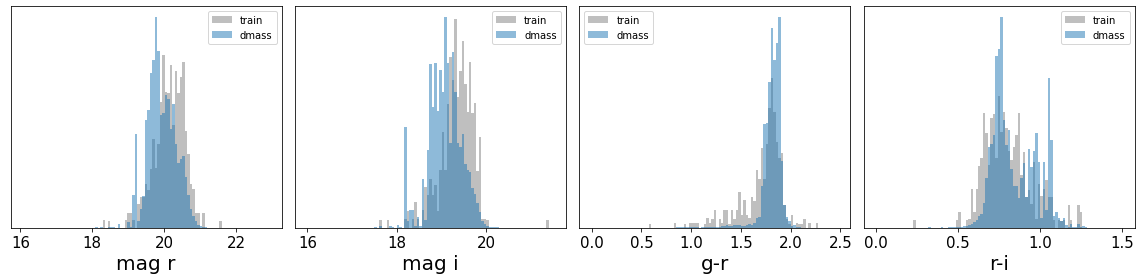

In [87]:
weight_dmass = gold_spt_test['CMASS_PROB']
doVisualization_1d(data=[X_cmass_true, X_dmass], 
                   weight = [None, weight_dmass],  # apply dmass weights
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train', 'dmass'], 
                   nbins=100)

In [88]:
#KS test:
from scipy import stats

#print(X_cmass_true.shape)
#print(X_dmass.shape)
#print(weight_dmass.shape)

#matching catalogs
#cuts to select RA and DEC

#numpy array slicing function 
#pass the first column etc.

Xdmass_magr=X_dmass[:,0]
Xdmass_magi=X_dmass[:,1]
Xdmass_gr=X_dmass[:,2]
Xdmass_ri=X_dmass[:,3]

Xcmass_magr=X_cmass_true[:,0]
Xcmass_magi=X_cmass_true[:,1]
Xcmass_gr=X_cmass_true[:,2]
Xcmass_ri=X_cmass_true[:,3]

print(Xdmass_magi.shape)
print(Xcmass_magr.shape)

stats.kstest(Xcmass_magr, Xdmass_magr)
stats.kstest(Xcmass_magi, Xdmass_magi)
stats.kstest(Xcmass_gr, Xdmass_gr)
stats.kstest(Xcmass_ri, Xdmass_ri)

#model training: make dist. match up more
#larger training set

######################################
#other notes:

#astro-coffee: once a week- depending on topic
#cosmology meeting Tuesday: 2pm-3pm (zoom)
#mailing list: subscribed?
#cosmolunch: present paper every so often

(100000,)
(100000,)


KstestResult(statistic=0.6279899999999999, pvalue=0.0)

In [ ]:
#create subsample:
#select all g-r values within an amount



In [37]:
#KS test sample (not same distribution):
from scipy import stats
#Arrays:
i=[0.125,0.375,0.375,0.5,0.5,0.875,1]
f=[0.285714,0.428571,0.714286,0.714286,0.857143,1,1]

stats.kstest(i,f)

KstestResult(statistic=0.42857142857142855, pvalue=0.5751748251748252)

In [38]:
#KS test sample 2 (same distribution):
from scipy import stats

m=[0.05, 0.1875, 0.25, 0.3375, 0.3375, 0.4, 0.5125, 0.675, 0.925, 1]
w=[0.112903, 0.177419, 0.193548, 0.370968, 0.564516, 0.629032, 0.66129, 0.725806, 0.854839, 1]

stats.kstest(m,w)

KstestResult(statistic=0.3, pvalue=0.7869297884777761)

(50000,)


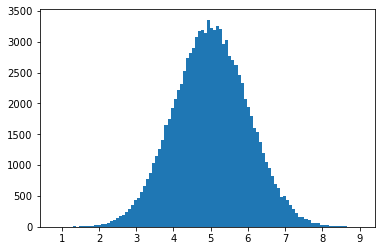

KstestResult(statistic=0.00384000000000001, pvalue=0.8532323035610377)

In [89]:
#data from the same distribution:
import numpy
import matplotlib.pyplot as plt
from scipy import stats

x = numpy.random.normal(5.0, 1.0, 100000)

#randomly select from array (twice):
x1=np.random.choice(x, 50000, replace=False)
x2=np.random.choice(x, 50000, replace=False)

print(x1.shape)
plt.hist(x, 100)
plt.show()

#check that ks test gives a correlation:
stats.kstest(x1,x2)

In [ ]:
#push to repo
#KS test by hand: double check 
#p value, X^2
#write out changing pieces
#main functions in code: input outputs-- Y3
####decide training set\validation set-- part of overlap data is only used for testing
#cross-validation of model while training
#decide once-- Su- what was considered during choice
#look at mock catalog-- Y3 realization of Y3 data-- mag. colors. simulated photo z-- use catalog and simulate DMASS by 
